<a href="https://colab.research.google.com/github/IsaacFigNewton/Smishing-Detector/blob/sklearn-approach/Smishing_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

<ol>
  <li>Blah</li>
</ol>

# Import and config

## Install packages

### Autocorrecters

In [1]:
# can't seem to get this to work, keep getting UnpicklingError: invalid load key, '<'. when loading pretrained model
# !pip install neuspell

In [2]:
# import neuspell
# # Sample text to correct
# sample_text = "Iate taht appl"
# print(sample_text)
# print()

# # BERT correction
# def bert_correct(text):
#     checker = neuspell.BertChecker()
#     checker.from_pretrained()
#     return checker.correct(text)

# bert_corrected = bert_correct(sample_text)

# print(f"BERT corrected: {bert_corrected}")

In [3]:
# # https://github.com/filyp/autocorrect
# !pip install autocorrect

In [4]:
# #https://github.com/keredson/wordninja
# !pip install wordninja

### Text Embedders

In [5]:
# https://sbert.net/
!pip install -U sentence-transformers

In [6]:
# https://github.com/MaartenGr/BERTopic
!pip install bertopic

## Import Libraries

In [128]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse
import re

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.metrics.pairwise import cosine_similarity,\
                                     cosine_distances

from sklearn.cluster import KMeans,\
                            SpectralClustering
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier,\
                            KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,\
                            DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,\
                            VotingClassifier,\
                            VotingRegressor,\
                            StackingRegressor
from sklearn.neural_network import MLPClassifier,\
                            MLPRegressor
from sklearn.model_selection import train_test_split,\
                            cross_val_score,\
                            GridSearchCV
from sklearn.decomposition import PCA

import seaborn as sns

In [8]:
import nltk
# nltk.download('punkt')
# from nltk.tokenize import punkt
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# Text preprocessing

import wordninja
from autocorrect import Speller

In [10]:
# Vectorizers

# TF-IDF
from sklearn.feature_extraction.text import CountVectorizer,\
                                            TfidfVectorizer

# Use BERT as the sentence encoder since it's the best open-source option
from sentence_transformers import SentenceTransformer

# use the bertopic text class vectorizer
from bertopic import BERTopic

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Set global variables

In [11]:
class_map = {"ham": 0, "spam": 1}
color_map = {0: "green", 1: "red"}

char_ngrams = (1, 6)
word_ngrams = (1, 3)
minSusLen = 500
lenWeight = 0.01

np.random.seed(42)
random_state = 0

## Create NLP preprocessors

In [12]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [13]:
# Regex for phone numbers
phone_regex = re.compile(r'(\+\d{1,2}\s?)?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}')

# Regex for emails
email_regex = re.compile(r'[A-Za-z0-9. _%-]+@[A-Za-z0-9. -]+\\. [A-Za-z]{2,4}')

# Regex for URLs
url_regex = re.compile(r'https?:\/\/(www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,6}(/[a-zA-Z0-9._~:/?#[\]@!$&\'()*+,;=-]*)?')

In [14]:
speller = Speller(lang="en")

## Create Embedding Models

In [15]:
def get_ngrams(document, word_ngram_range=(1, 3), char_ngram_range=(1, 3)):
    # Get word n-grams
    word_vectorizer = CountVectorizer(ngram_range=word_ngram_range, analyzer='word')
    word_analyzer = word_vectorizer.build_analyzer()
    word_ngrams = word_analyzer(document)

    # Get character n-grams
    char_vectorizer = CountVectorizer(ngram_range=char_ngram_range, analyzer='char')
    char_analyzer = char_vectorizer.build_analyzer()
    char_ngrams = char_analyzer(document)

    return char_ngrams + word_ngrams

In [16]:
# create the tfidf vectorizer
vec = TfidfVectorizer(\
                      analyzer=get_ngrams,\
                      ngram_range=word_ngrams,\
                      norm="l2",\
                      min_df=0.001,\
                      max_df=0.9,\
                      sublinear_tf=False)

# Load a pretrained Sentence Transformer model
sentence_embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Load a pretrained topic embedding model
# https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html#language
topic_model = BERTopic(top_n_words=15,\
                       n_gram_range=word_ngrams,\
                       min_topic_size=10,\
                       nr_topics=50,\
                       calculate_probabilities=True)

#Import and clean data

##Important Functions

In [17]:
def get_contact_counts(doc):
    # Find phone numbers
    phones = phone_regex.findall(doc)

    # Find emails
    emails = email_regex.findall(doc)

    # Find URLs
    urls = url_regex.findall(doc)

    return (len(phones), len(emails), len(urls))

In [18]:
def leet_to_english(text):
    leet_dict = {
        '0': 'o',
        '1': 'l',
        '3': 'e',
        '4': 'a',
        '5': 's',
        '7': 't',
        '8': 'b',
        '9': 'g'
    }

    # Add common leet transformations if needed
    for leet, eng in leet_dict.items():
        text = text.replace(leet, eng)

    return text

## Import, Prepare data

In [19]:
corpus = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Smishing-Detector/sklearn-approach/dataset/SMSSpamCollection.txt", sep="\t", on_bad_lines='warn')

# clean the corpus
corpus = corpus.dropna(axis=0)

# rename dataset columns
corpus.columns = ["class", "text"]

# save data info for later exploration
corpus_counts = corpus["class"].value_counts()

# convert the class to a numeric value
corpus["class"] = corpus["class"].map(class_map)

# get a subset of the dataset for model testing before training on whole dataset
corpus = corpus.loc[:1000]

In [138]:
corpus["color"] = corpus["class"].map(color_map)

In [20]:
print(corpus_counts)

class
ham     4824
spam     747
Name: count, dtype: int64


## Clean Data and Extract Features

In [21]:
# extract numerical features

# count number of integers
corpus["num_digits"] = corpus["text"].apply(lambda s: sum(word.isdigit() for word in s.split()))

# get the number of contacts in the sms
# corpus["phone_count", "email_count", "url_count"] = corpus["text"].apply(lambda x: get_contact_counts(x))
contact_counts = corpus["text"].apply(lambda x: get_contact_counts(x))
corpus["phone_count"] = contact_counts.apply(lambda x: x[0])
corpus["email_count"] = contact_counts.apply(lambda x: x[1])
corpus["url_count"] = contact_counts.apply(lambda x: x[2])

In [22]:
# extract character features

# get the number of characters in the sms
corpus["char_count"] = corpus["text"].apply(lambda x: len(x))

# get the number of unique characters in the sms
corpus["unique_char_count"] = corpus["text"].apply(lambda x: len(set(x)))

In [23]:
# remove numerical features from base text

# remove contact info from text, replacing it with filler
corpus["text_with_replacements"] = corpus["text"].apply(lambda x: re.sub(phone_regex, "phone", x))
corpus["text_with_replacements"] = corpus["text"].apply(lambda x: re.sub(email_regex, "email", x))
corpus["text_with_replacements"] = corpus["text"].apply(lambda x: re.sub(url_regex, "url", x))

In [24]:
# test_str = "Iate taht appl"
# print("Test string: " + test_str)
# print()

# split_str = " ".join(wordninja.split(test_str))
# corrected_str = speller(test_str)
# print("Split string: " + split_str)
# print("Corrected string: " + corrected_str)
# print()
# print("Split Corrected string: " + " ".join(wordninja.split(corrected_str)))
# print("Corrected Split string: " + speller(split_str))

In [25]:
# fix common leet replacements
# corpus["text_with_replacements"] = corpus["text"].apply(lambda x: leet_to_english(x))

# # probabilistically break up any words with missing spaces
# corpus["text_with_replacements"] = corpus["text_with_replacements"].apply(lambda x: " ".join(wordninja.split(x)))

# # correct spelling for better embedding
# corpus["text_with_replacements"] = corpus["text_with_replacements"].apply(lambda x: speller(x))

# remove stop words and lemmatize text
# corpus["text_with_replacements"] = corpus["text_with_replacements"]\
#                                       .apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))

In [26]:
# extract word features

# get the number of words in the sms
corpus["word_count"] = corpus["text_with_replacements"].apply(lambda x: len(x.split()))

# get the number of unique words in the sms
corpus["unique_word_count"] = corpus["text_with_replacements"].apply(lambda x: len(set(x.split())))

In [27]:
scaler = Normalizer()
cols_to_normalize = ["word_count", "char_count", "unique_word_count", "unique_char_count", "num_digits", "phone_count", "email_count", "url_count"]
scaled_cols_to_normalize = ["scaled_" + col for col in cols_to_normalize]

# Normalize value count columns
corpus[scaled_cols_to_normalize] = scaler.fit_transform(corpus[cols_to_normalize].values)

In [28]:
corpus.head()

,class,text,num_digits,phone_count,email_count,url_count,char_count,unique_char_count,text_with_replacements,word_count,unique_word_count,scaled_word_count,scaled_char_count,scaled_unique_word_count,scaled_unique_char_count,scaled_num_digits,scaled_phone_count,scaled_email_count,scaled_url_count
0,0,Ok lar... Joking wif u oni...,0,0,0,0,29,15,Ok lar... Joking wif u oni...,6,6,0.177861,0.859660,0.177861,0.444652,0.000000,0.000000,0.0,0.0
1,1,Free entry in 2 a wkly comp to win FA Cup fina...,2,1,0,0,155,39,Free entry in 2 a wkly comp to win FA Cup fina...,28,24,0.170684,0.944859,0.146301,0.237739,0.012192,0.006096,0.0,0.0
2,0,U dun say so early hor... U c already then say...,0,0,0,0,49,16,U dun say so early hor... U c already then say...,11,10,0.205044,0.913378,0.186404,0.298246,0.000000,0.000000,0.0,0.0
3,0,"Nah I don't think he goes to usf, he lives aro...",0,0,0,0,61,21,"Nah I don't think he goes to usf, he lives aro...",13,12,0.194333,0.911871,0.179384,0.313923,0.000000,0.000000,0.0,0.0
4,1,FreeMsg Hey there darling it's been 3 week's n...,1,0,0,0,147,40,FreeMsg Hey there darling it's been 3 week's n...,32,31,0.201601,0.926105,0.195301,0.252001,0.006300,0.000000,0.0,0.0


# Data Exploration

## Important Functions

In [29]:
def plot_freqs(col, xlabel, ylabel, title):
  plt.figure(figsize=(15, 5))
  plt.hist(corpus[corpus['class']==0][col],\
          bins=50,\
          label='Ham',\
          alpha=0.5)
  plt.hist(corpus[corpus['class']==1][col],\
          bins=50,\
          label='Spam',\
          alpha=0.5)
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

## Plots, Charts, Diagrams

<Axes: xlabel='class'>

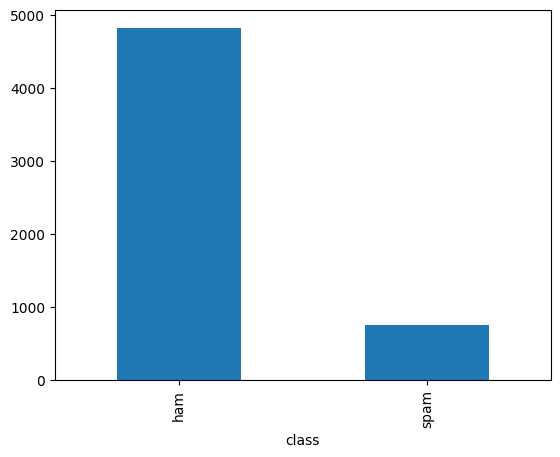

In [30]:
corpus_counts.plot.bar()

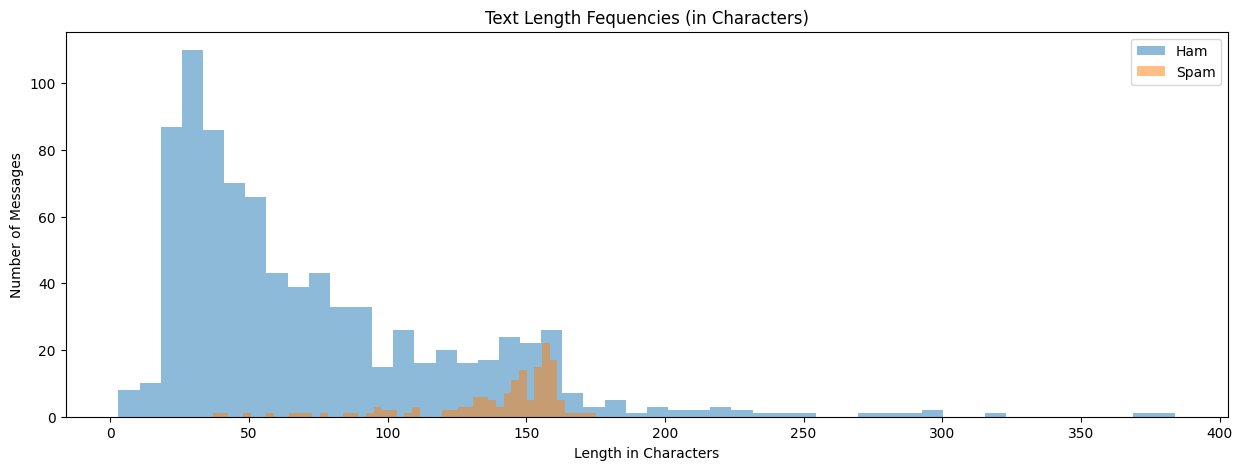

In [31]:
# frequency plot of lengths in characters
plot_freqs("char_count", 'Length in Characters', 'Number of Messages', "Text Length Fequencies (in Characters)")

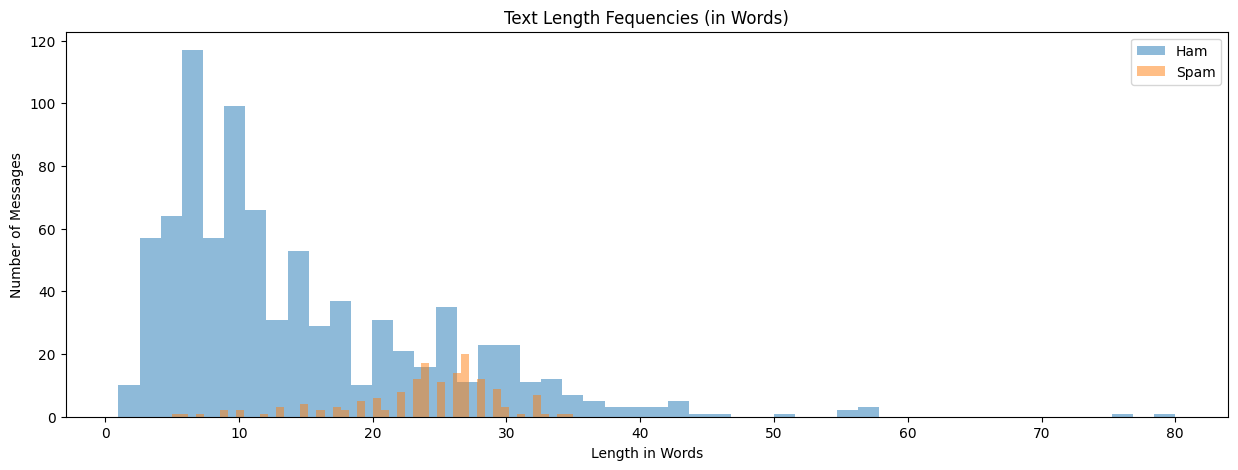

In [32]:
# frequency plot of lengths
plot_freqs("word_count", 'Length in Words', 'Number of Messages', "Text Length Fequencies (in Words)")

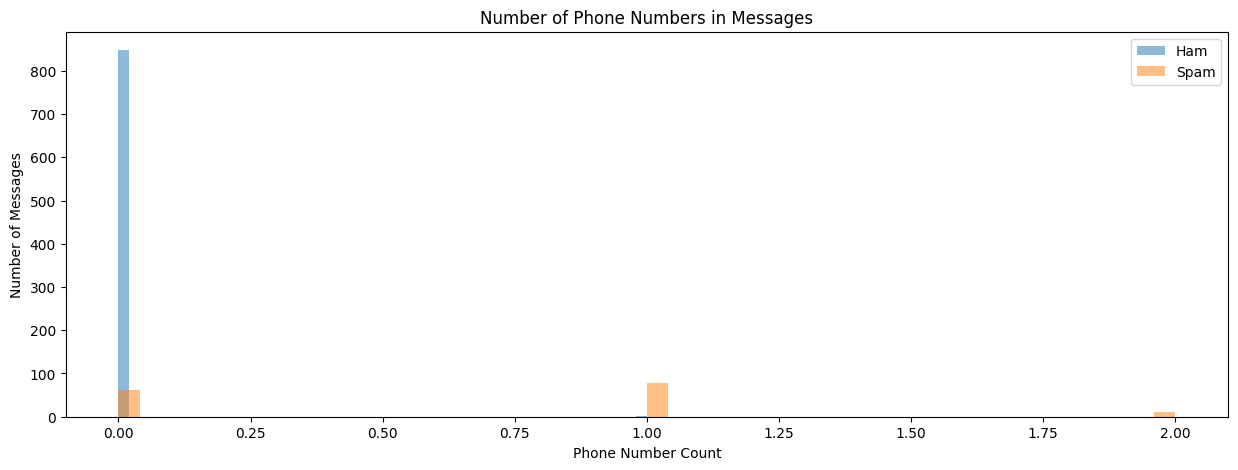

In [33]:
# frequency plot of lengths
plot_freqs("phone_count", "Phone Number Count", 'Number of Messages', "Number of Phone Numbers in Messages")

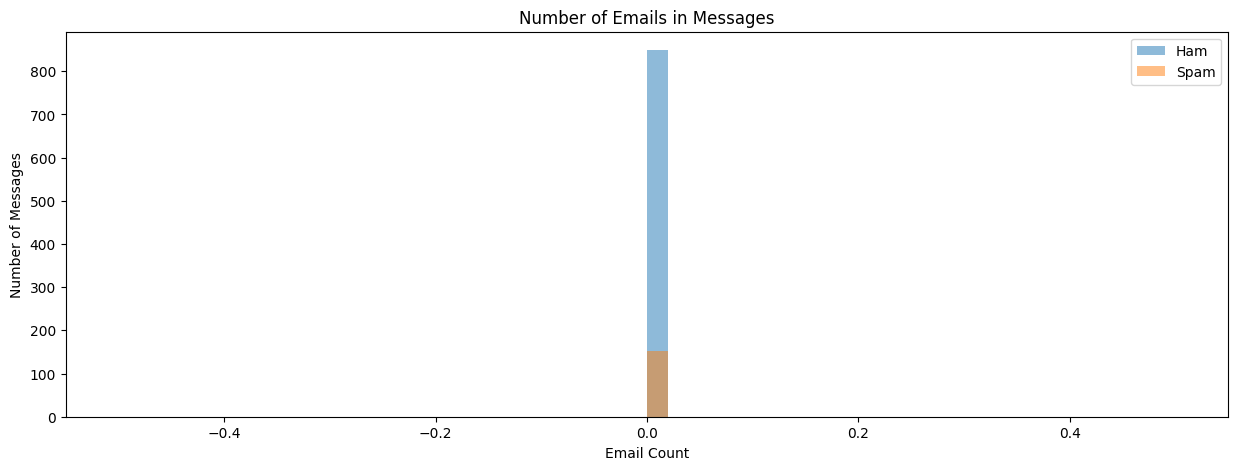

In [34]:
# frequency plot of lengths
plot_freqs("email_count", "Email Count", 'Number of Messages', "Number of Emails in Messages")

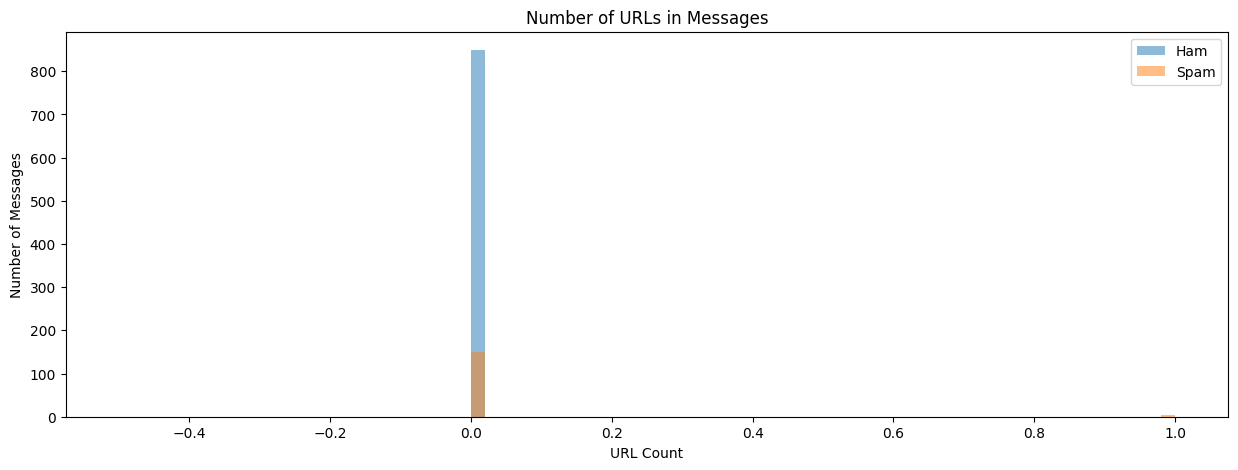

In [35]:
# frequency plot of lengths
plot_freqs("url_count", "URL Count", 'Number of Messages', "Number of URLs in Messages")

# Embed the text in vector spaces

## Vectorize Corpus

In [36]:
# Function to extract the number from the topic string
def extract_number(topic):
    return int(topic.split()[1])

In [37]:
# TF-IDF vectorizer
vec.fit(corpus["text_with_replacements"])
corpus_tfidf_vects = vec.transform(corpus["text_with_replacements"])

# BERTopic topic vectorizer
bertopic_topics, bertopic_probs = topic_model.fit_transform(corpus["text_with_replacements"])

# BERT sentence embedder
bert_embeddings = sentence_embedder.encode(corpus["text_with_replacements"])

In [38]:
# get topic assignments
bertopic_topics_probs_df = pd.DataFrame(data = bertopic_probs,\
                            columns=["Topic " + str(i) + " Probability" for i in range(len(set(bertopic_topics)) - 1)]\
)

# Ensure only numeric columns are used for finding max values and their indices
numeric_bertopic = bertopic_topics_probs_df.select_dtypes(include=[float, int])

# Get the assigned topic, which may not exist, in which case it will be -1
bertopic_topics_probs_df["Assigned Topic"] = pd.Series(bertopic_topics)
# Get the topic with the highest probability for each row
bertopic_topics_probs_df["Predicted Topic"] = numeric_bertopic\
                                          .idxmax(axis=1, skipna=True)\
                                          .apply(extract_number)

# Get the associated max probability of topic association for each row
bertopic_topics_probs_df["Predicted Topic Probability"] = numeric_bertopic.max(axis=1, skipna=True)

# print(test_topics_probs_df.dtypes)
bertopic_topics_probs_df.head()

,Topic 0 Probability,Topic 1 Probability,Topic 2 Probability,Topic 3 Probability,Topic 4 Probability,Topic 5 Probability,Topic 6 Probability,Topic 7 Probability,Topic 8 Probability,Topic 9 Probability,Topic 10 Probability,Topic 11 Probability,Topic 12 Probability,Topic 13 Probability,Topic 14 Probability,Assigned Topic,Predicted Topic,Predicted Topic Probability
0,0.030035,0.055843,0.028499,0.018096,0.039467,0.020604,0.018586,0.067923,0.338212,0.106573,0.052211,0.042424,0.039970,0.042048,0.051698,8,8,0.338212
1,0.033699,0.023089,0.040007,0.353627,0.014021,0.051440,0.045699,0.016692,0.015854,0.020304,0.013267,0.012257,0.017474,0.016317,0.017009,3,3,0.353627
2,0.036769,0.048817,0.027763,0.021112,0.060450,0.022421,0.019864,0.048097,0.070805,0.085355,0.050128,0.109210,0.084966,0.041453,0.111117,-1,14,0.111117
3,0.031080,0.041964,0.030478,0.019246,0.034806,0.022984,0.019738,0.417904,0.072077,0.065664,0.036266,0.029986,0.031687,0.055439,0.055589,7,7,0.417904
4,0.028881,0.027395,0.132607,0.033764,0.012291,0.036774,0.032151,0.016805,0.015813,0.019659,0.012193,0.010487,0.014878,0.015231,0.015243,2,2,0.132607


In [39]:
# Reformat general counts, embedding and topic data

# Put count columns into their own sparse matrix for later concatenation
corpus_counts = sparse.csr_matrix(corpus[scaled_cols_to_normalize])

# Put embeddings into their own sparse matrices
corpus_bert_embeddings = sparse.csr_matrix(bert_embeddings)

corpus_bert_topics_probs = sparse.csr_matrix(bertopic_topics_probs_df)

## Combine general counts, TFIDF, sentence embeddings, and topic classifications

In [40]:
print(corpus_counts.shape)
print(corpus_tfidf_vects.shape)
print(corpus_bert_embeddings.shape)
print(corpus_bert_topics_probs.shape)

(1001, 8)
(1001, 8759)
(1001, 384)
(1001, 18)


In [41]:
# Doing hstack directly was ineffective

# Convert sparse matrices to dense arrays
corpus_counts_dense = corpus_counts.toarray()
corpus_tfidf_vects_dense = corpus_tfidf_vects.toarray()
corpus_bert_embeddings_dense = corpus_bert_embeddings.toarray()
corpus_bert_topics_probs_dense = corpus_bert_topics_probs.toarray()

# Horizontally stack dense arrays, must use >=2 features
# corpus_features_to_use = (corpus_counts_dense, corpus_tfidf_vects_dense, corpus_bert_embeddings_dense, corpus_bert_topics_probs_dense)
corpus_features_to_use = (corpus_counts_dense, corpus_tfidf_vects_dense)

# Combine the dense matrix
all_corpus_embeddings_dense = np.hstack(corpus_features_to_use)

# Convert back to sparse matrix
all_corpus_embeddings = sparse.csr_matrix(all_corpus_embeddings_dense)

In [42]:
print(all_corpus_embeddings.shape)

(1001, 8767)


# Vector Space Exploration

## BERTopic Embeddings

In [127]:
bertopic_topics_probs_df.head()

,Topic 0 Probability,Topic 1 Probability,Topic 2 Probability,Topic 3 Probability,Topic 4 Probability,Topic 5 Probability,Topic 6 Probability,Topic 7 Probability,Topic 8 Probability,Topic 9 Probability,Topic 10 Probability,Topic 11 Probability,Topic 12 Probability,Topic 13 Probability,Topic 14 Probability,Assigned Topic,Predicted Topic,Predicted Topic Probability
0,0.030035,0.055843,0.028499,0.018096,0.039467,0.020604,0.018586,0.067923,0.338212,0.106573,0.052211,0.042424,0.039970,0.042048,0.051698,8,8,0.338212
1,0.033699,0.023089,0.040007,0.353627,0.014021,0.051440,0.045699,0.016692,0.015854,0.020304,0.013267,0.012257,0.017474,0.016317,0.017009,3,3,0.353627
2,0.036769,0.048817,0.027763,0.021112,0.060450,0.022421,0.019864,0.048097,0.070805,0.085355,0.050128,0.109210,0.084966,0.041453,0.111117,-1,14,0.111117
3,0.031080,0.041964,0.030478,0.019246,0.034806,0.022984,0.019738,0.417904,0.072077,0.065664,0.036266,0.029986,0.031687,0.055439,0.055589,7,7,0.417904
4,0.028881,0.027395,0.132607,0.033764,0.012291,0.036774,0.032151,0.016805,0.015813,0.019659,0.012193,0.010487,0.014878,0.015231,0.015243,2,2,0.132607


<Axes: ylabel='Frequency'>

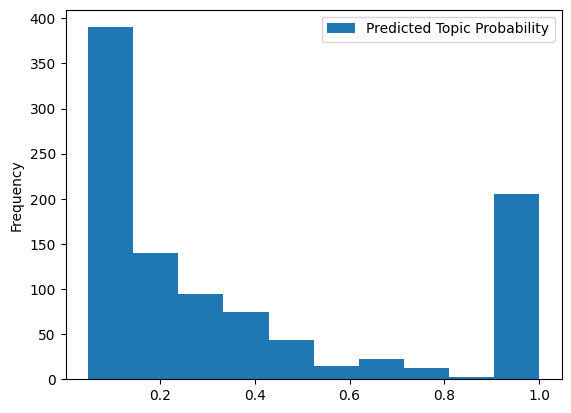

In [126]:
bertopic_topics_probs_df.plot.hist(x="Predicted Topic", y="Predicted Topic Probability")

<Axes: title={'center': 'Topic Frequencies'}, xlabel='Predicted Topic', ylabel='Frequency'>

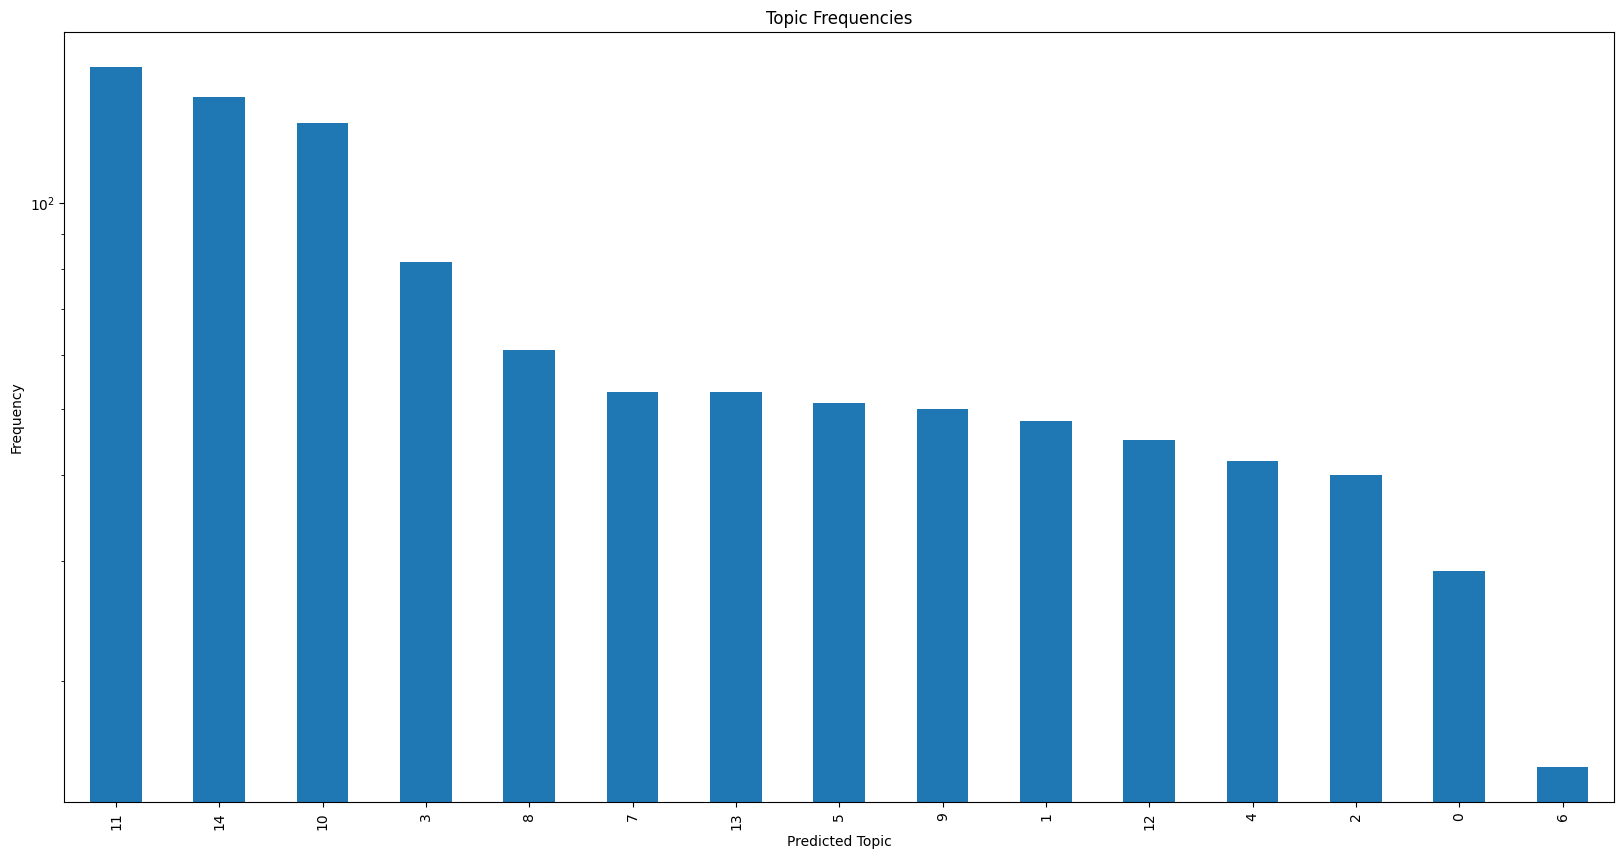

In [123]:
bertopic_topics_probs_df["Predicted Topic"]\
  .value_counts()\
  .plot\
  .bar(logy=True, figsize=(20, 10), xlabel="Predicted Topic", ylabel="Frequency", title="Topic Frequencies")

<Axes: title={'center': 'Topic Frequencies'}, xlabel='Assigned Topic', ylabel='Frequency'>

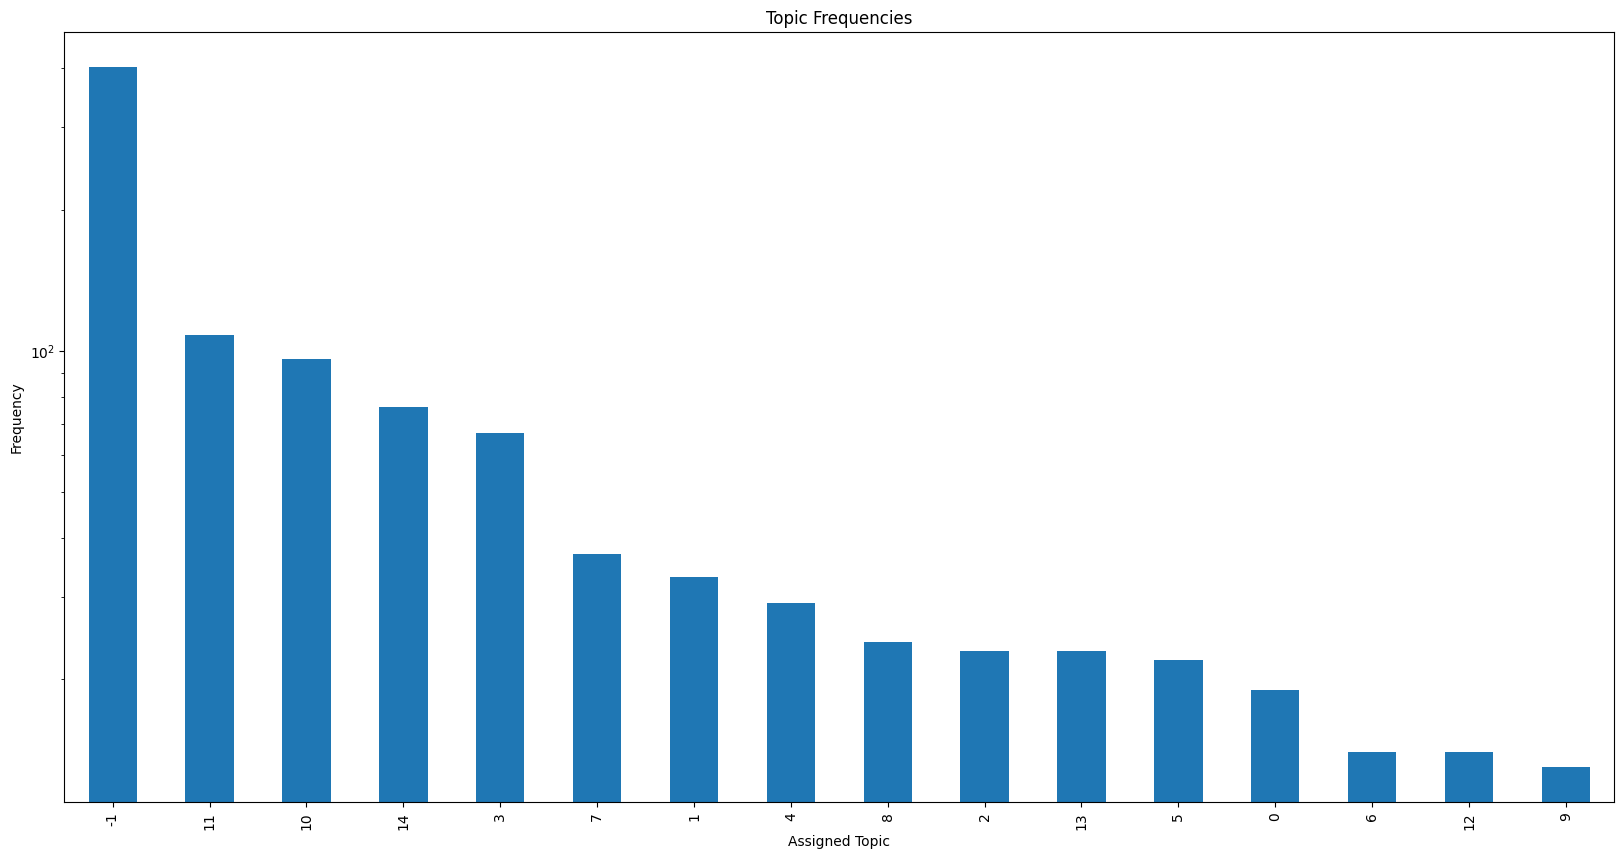

In [124]:
bertopic_topics_probs_df["Assigned Topic"]\
  .value_counts()\
  .plot\
  .bar(logy=True, figsize=(20, 10), xlabel="Assigned Topic", ylabel="Frequency", title="Topic Frequencies")

## Sentence Embeddings

## PCA

In [153]:
pca = PCA(n_components=4)
components = pca.fit_transform(all_corpus_embeddings_dense)

# Create a DataFrame with the principal components
column_names = ["PC" + str(i) for i in range(components.shape[1])]
pca_df = pd.DataFrame(components, columns=column_names)

pca_df.head()

,PC0,PC1,PC2,PC3
0,0.250774,-0.046220,0.346812,-0.020583
1,-0.159996,0.334711,0.020443,-0.000459
2,0.034200,-0.098229,0.300894,-0.015021
3,-0.039001,-0.119018,-0.047570,-0.004783
4,-0.144086,0.012285,-0.027050,-0.029467


In [154]:
explained_variance_ratios_df = pd.DataFrame({
    "Component": [i for i in range(components.shape[1])],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
})

explained_variance_ratios_df.head()

,Component,Explained Variance Ratio
0,0,0.028149
1,1,0.018455
2,2,0.012984
3,3,0.012410


<Axes: xlabel='Component'>

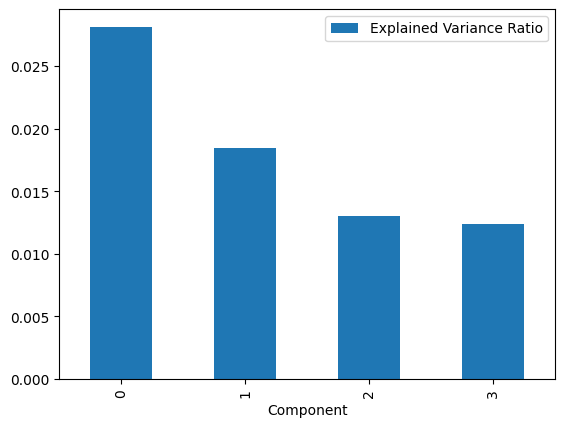

In [155]:
explained_variance_ratios_df.plot.bar(x="Component", y="Explained Variance Ratio")

<Axes: xlabel='PC0', ylabel='PC1'>

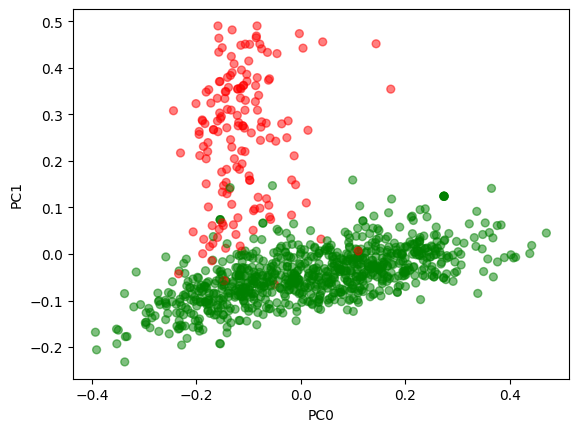

In [156]:
pca_df.plot(kind='scatter', x='PC0', y='PC1', s=32, alpha=.5, c=corpus['color'])

<Axes: xlabel='PC1', ylabel='PC2'>

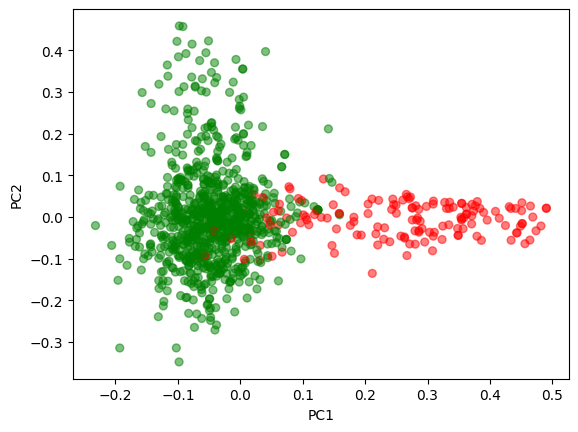

In [157]:
pca_df.plot(kind='scatter', x='PC1', y='PC2', s=32, alpha=.5, c=corpus['color'])

<Axes: xlabel='PC2', ylabel='PC3'>

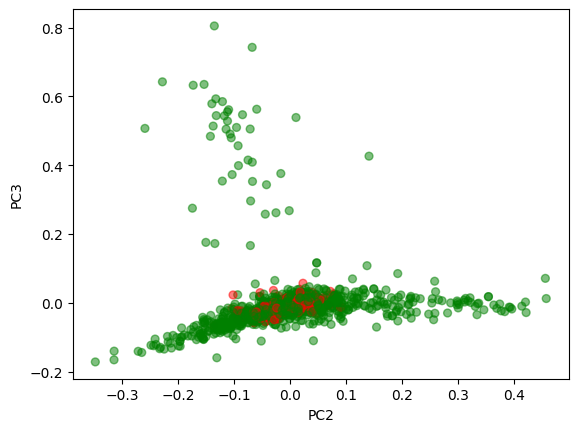

In [158]:
pca_df.plot(kind='scatter', x='PC2', y='PC3', s=32, alpha=.5, c=corpus['color'])

# Classification and Model Evaluation

## Models

In [46]:
# Classifiers
# Unsupervised
km = KMeans(n_clusters=2, random_state=random_state)
spectral = SpectralClustering(n_clusters=2, random_state=random_state)

# Supervised
nb = GaussianNB()
svc = SVC(kernel="linear")

In [47]:
# Regressors
lr = LinearRegression()
knn = KNeighborsRegressor(n_neighbors=5)
dt = DecisionTreeRegressor()
mlp = MLPRegressor(random_state=random_state,\
                    max_iter=1000,\
                    learning_rate_init=0.01\
)

In [48]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)

# Stacking Regressor
stacking_regressor = StackingRegressor(\
                            estimators=[
                                ("Linear Regression", lr),
                                ("K-Nearest Neighbors", knn),
                                ("Decision Tree", dt),
                                ("Multi-Layer Perceptron", mlp)
                            ],
                            final_estimator=LinearRegression(),
                            cv = 5)

# create the voting classifier later, once the stacker has been fit to the data

## Important Functions

In [49]:
def get_voting_classifier():
    # Extract the coefficients from the final estimator
    final_estimator = stacking_regressor.final_estimator_
    coefficients = final_estimator.coef_
    print("Coefficients from the final estimator:", coefficients)

    # Create voting classifier
    voting = VotingRegressor(\
                            estimators=[
                              ("Linear Regression", lr),
                              ("K-Nearest Neighbors", knn),
                              ("Decision Tree", dt),
                              ("Multi-Layer Perceptron", mlp)],
                            weights=coefficients)

    return voting

In [50]:
def get_spam_cv_scores(X, y, cv=5, metric="f1"):

    scores = pd.DataFrame({
        "Decision Tree": cross_val_score(dt, X, y, cv=cv, scoring=metric),
        "K Means": cross_val_score(km, X, y, cv=cv, scoring=metric),
        "K Nearest Neighbor": cross_val_score(knn, X, y, cv=cv, scoring=metric),
        "Linear Regression": cross_val_score(lr, X, y, cv=cv, scoring=metric),
        "Multi-Layer Perceptron": cross_val_score(mlp, X, y, cv=cv, scoring=metric),
        "Naive Bayes": cross_val_score(nb, X, y, cv=cv, scoring=metric),
        "Spectral Clustering": cross_val_score(spectral, X, y, cv=cv, scoring=metric),
        "Support Vector": cross_val_score(svc, X, y, cv=cv, scoring=metric),
        "Random Forest": cross_val_score(rf, X, y, cv=cv, scoring=metric) #,
        # "Voting Classifier": cross_val_score(get_voting_classifier(), X, y, cv=cv, scoring=metric)
    })

    return scores

In [51]:
def format(stat):
    return "\t" + str('%.3f'%stat)

In [90]:
def get_model_scores(X, y, cv=5, metric="f1"):
  # get the scores for the metric and drop irrelevant columns
  cv_scores = get_spam_cv_scores(all_corpus_embeddings_dense, corpus["class"], cv, metric)
  cv_scores.dropna(axis=1, how="any", inplace=True)

  # create a new df with just the mean cross-validation scores
  cv_score_means = pd.DataFrame({
      "Model":    list(cv_scores.columns),
      "Metric":   [metric]*len(cv_scores.columns),
      "Score": cv_scores.mean(axis=0)
      })

  return cv_score_means

In [97]:
# import sklearn
# sklearn.metrics.get_scorer_names()

In [96]:
def get_score_means_df():
  scores_dfs = []
  for metric in ["accuracy", "precision", "recall", "f1"]:
    scores_dfs.append(get_model_scores(all_corpus_embeddings_dense, corpus["class"], 5, metric))

  return pd.concat(scores_dfs, ignore_index=True)

## Classify

In [118]:
score_means_df = get_score_means_df()

,Model,Metric,Score
0,Decision Tree,accuracy,0.959055
1,K Means,accuracy,0.478602
2,Naive Bayes,accuracy,0.981015
3,Support Vector,accuracy,0.984025
4,Random Forest,accuracy,0.979025
5,Decision Tree,precision,0.892227
6,K Means,precision,0.111254
7,Naive Bayes,precision,0.940845
8,Support Vector,precision,0.993103
9,Random Forest,precision,0.984900


In [ ]:
score_means_df

## Model Comparison

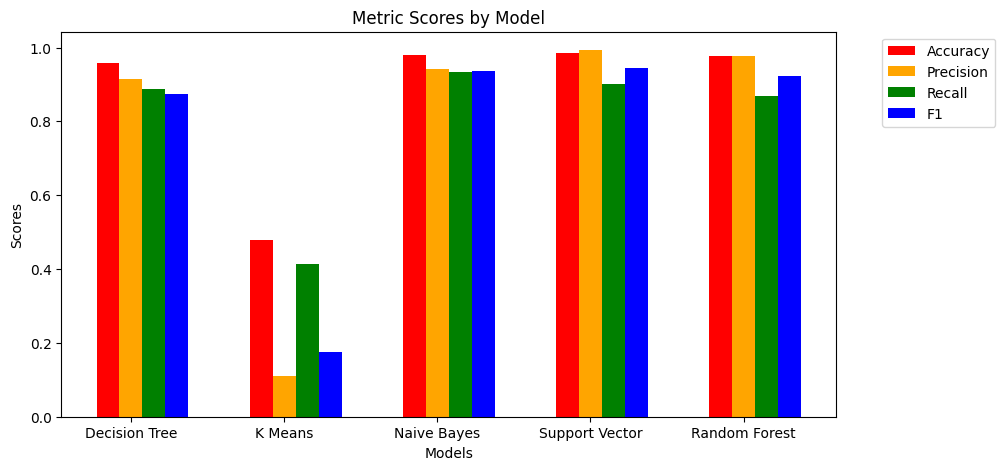

In [117]:
N = 5
ind = np.arange(N)
width = 0.15

# Extract data as lists for plotting
accuracy_scores = score_means_df[score_means_df["Metric"] == "accuracy"]["Score"].tolist()
precision_scores = score_means_df[score_means_df["Metric"] == "precision"]["Score"].tolist()
recall_scores = score_means_df[score_means_df["Metric"] == "recall"]["Score"].tolist()
f1_scores = score_means_df[score_means_df["Metric"] == "f1"]["Score"].tolist()

plt.figure(figsize=(10, 5))

bar1 = plt.bar(ind, accuracy_scores, width, color='r')
bar2 = plt.bar([i + width for i in ind], precision_scores, width, color='orange')  # Adjust positions for bars
bar3 = plt.bar([i + 2 * width for i in ind], recall_scores, width, color='g')
bar4 = plt.bar([i + 3 * width for i in ind], f1_scores, width, color='b')

# Add labels and title
plt.xlabel("Models")
plt.ylabel('Scores')
plt.title("Metric Scores by Model")

plt.xticks(ind+width, score_means_df["Model"].unique())
# Display legend separately
plt.legend((bar1, bar2, bar3, bar4), ("Accuracy", "Precision", "Recall", "F1"), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()